In [3]:
from scipy.io import loadmat
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
import os
import shutil as sh
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from sklearn.metrics import mean_squared_error
import h5py
import os
from sklearn.linear_model import LinearRegression, Lasso
from scipy.interpolate import interp1d

In [30]:
data = pd.read_csv('data.csv', index_col=0)

RAW = 'raw/'
ROOT = './'

def read_mask(filename, datadir=RAW):
    filename = datadir + 'labeledDataNPY/' + filename + '.npy'
    mask = np.load(filename)
    return mask

def read_rgb_fruit(filename, datadir=ROOT):
    image = io.imread(datadir + 'rgb/' + filename + '.png')[:,:,:3]
    return image

def read_image_fruit(filename, datadir=RAW, interpolate=True):
    with h5py.File(datadir + 'normalizedHSI/' + filename + '.h5', "r") as f:
        # List all groups
        a_group_key = list(f.keys())[0]
        # Get the data
        data = list(f[a_group_key])
        data = np.stack(data,axis=-1)
        if interpolate:
            data = interp1d(wl_,data,axis=2)(wl)
    return data

#wl = np.linspace(400,730,34)
wl = np.linspace(400,950,68)
wl0 = 397.32
wl1 = 1003.58
wl_ = np.linspace(wl0,wl1,204)

fruit_dict = {
 7 : 'apple',
 6 : 'orange',
 8 : 'pepper',
 3 : 'grape',
 4 : 'green plants',
 5 : 'lemons',
 11 : 'avocado',
 9 : 'bananas',
 12 : 'starfruit',
 10 : 'unknown',
 2 : 'onion',
 1 : 'potato'
}
import pickle
with open('class.dic','rb') as f:
    class_dic=pickle.load(f)

SMALL_SIZE = 17
MEDIUM_SIZE = 18
BIGGER_SIZE = 23

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

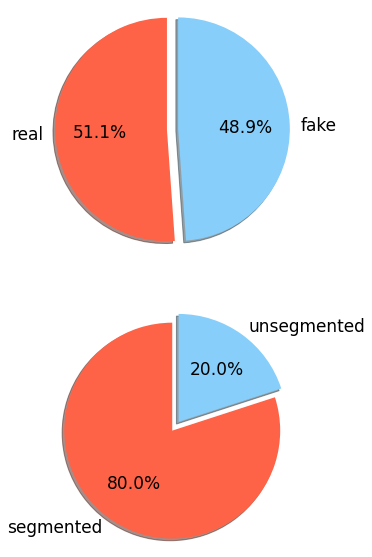

In [26]:
nreals = ''.join(data.realfake.tolist()).count('r')
nfakes = ''.join(data.realfake.tolist()).count('f')
data_segmented = data[data.masks==True]
nsegmented = len(data_segmented)
nunsegmented = len(data) - nsegmented
nreals/(nreals+nfakes), nfakes/(nreals+nfakes)
#################################################################
plt.figure(figsize=[5,10])
plt.subplot(211)
plt.pie([nreals,nfakes], explode=[0,0.1], labels=['real','fake'], autopct='%1.1f%%',
        shadow=True, startangle=90, colors = ['tomato','lightskyblue'])
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.subplot(212)
plt.pie([nsegmented,nunsegmented], explode=[0,0.1], labels=['segmented','unsegmented'], autopct='%1.1f%%',
        shadow=True, startangle=90, colors=['tomato','lightskyblue'])
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#################################################################
#plt.savefig('figures/dataset/stat.pdf', transparent=True, dpi = 300)
plt.show()
#plt.close()

In [27]:
realfake = ''.join(data.realfake.tolist()).replace('/','')
fruits = ''.join(data.fruit.tolist()).replace('/','')
print(len(realfake), len(fruits))

1289 1289


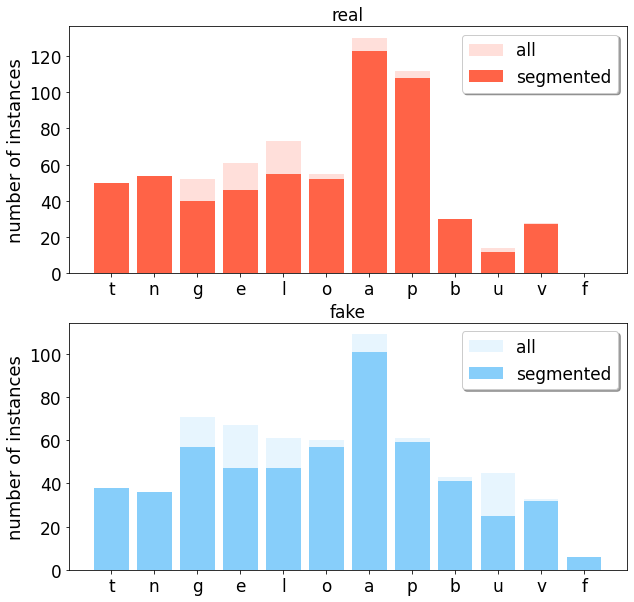

In [28]:
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)



def count_fruits(data, rf='r'):
    realfake = np.array(list(''.join(data.realfake.tolist()).replace('/','')))
    fruitss = np.array(list(''.join(data.fruit.tolist()).replace('/','')))
    fruits = {}
    for fruit in class_dic:
        mask = realfake == rf
        maskf = fruitss[mask] == fruit
        fruits[fruit] = len(fruitss[mask][maskf])
    return fruits.values()
fruits = count_fruits(data)
fruits_segmented = count_fruits(data[data.masks==True])
fruits, fruits_segmented
cshift = 0
plt.figure(figsize=[10,10])
plt.subplot(211)
plt.title('real')
plt.bar(class_dic.keys(), fruits, alpha=0.2, color='tomato',label='all')
plt.bar(class_dic.keys(), fruits_segmented, color='tomato',label='segmented')
plt.ylabel('number of instances')
plt.legend(fancybox=True, framealpha=1, shadow=True)
plt.subplot(212)
plt.title('fake')
fruits = count_fruits(data,'f')
fruits_segmented = count_fruits(data[data.masks==True],'f')
fruits, fruits_segmented
plt.bar(class_dic.keys(), fruits, alpha=0.2, color='lightskyblue',label='all')
plt.bar(class_dic.keys(), fruits_segmented, color='lightskyblue',label='segmented')
plt.ylabel('number of instances')
plt.legend(fancybox=True, framealpha=1, shadow=True)
plt.show()

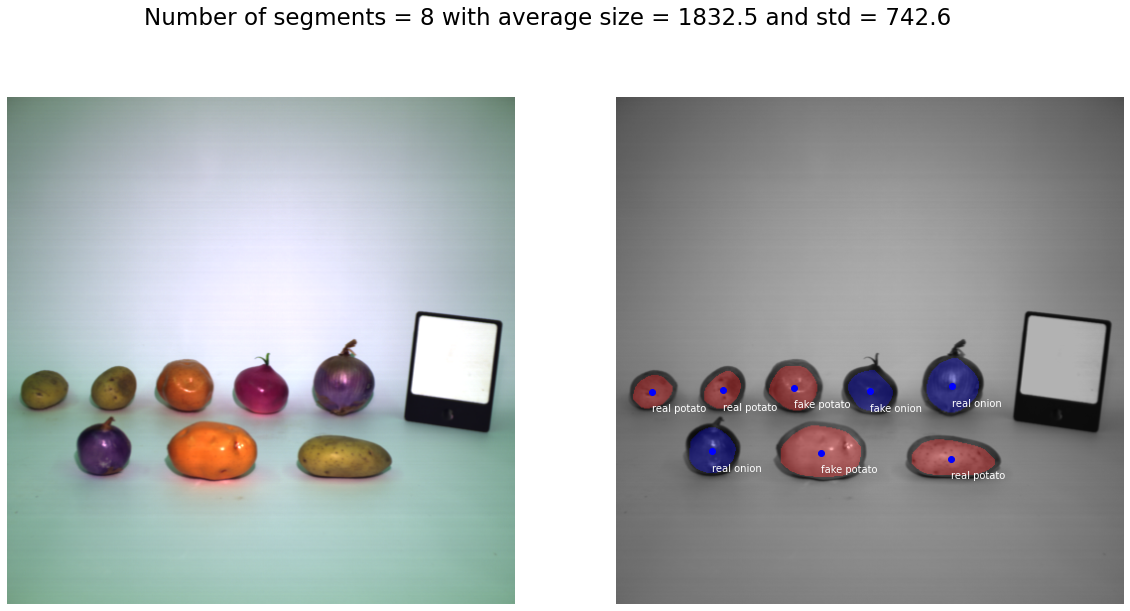

In [31]:
from IPython.display import clear_output
from skimage.color import label2rgb
from segment import FruitSegmentation

sample = data_segmented.sample(1)
for fname in data_segmented.names.values:
    clear_output(wait=2)
    mask = read_mask(fname)
    rgb = read_rgb_fruit(fname)
    fruit = FruitSegmentation(rgb, mask)
    fruit.fit()
    plt.figure(figsize=[20,10])
    fruit.show(with_summary=True, fontsize=10)
    plt.show()

2021-11-04_106


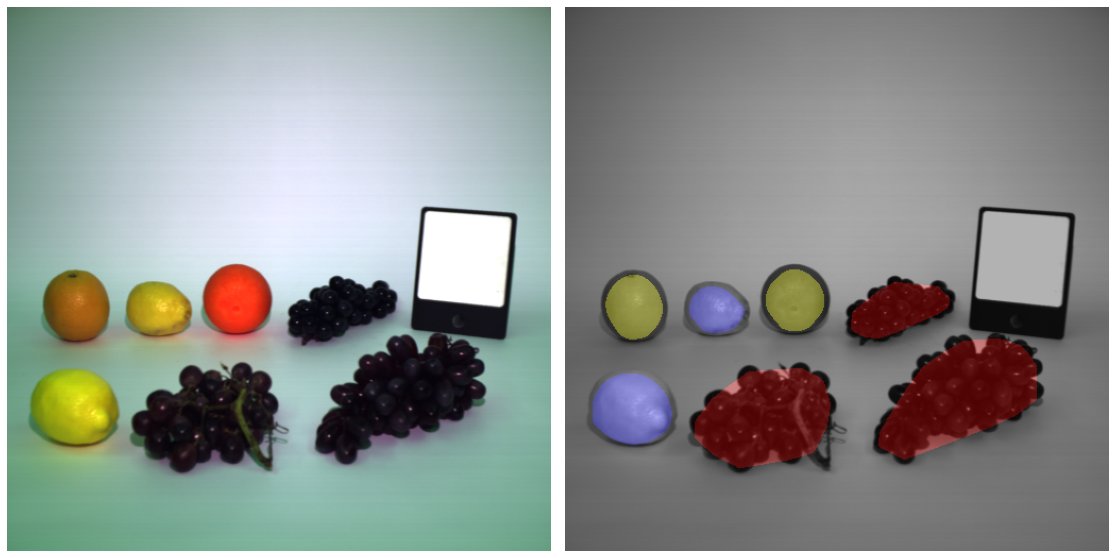

In [33]:
multicolumn = data_segmented[data_segmented.fruit.map(lambda x: '/' in x)]
sample = multicolumn.sample(1)
#fname = sample.names.values[0]
fname = '2021-11-04_106'
print(fname)
mask = read_mask(fname)
rgb = read_rgb_fruit(fname)
hyspec = read_image_fruit(fname)
fruit = FruitSegmentation(rgb, mask, hyspec)
fruit.fit()
plt.figure(figsize=[20,10])
fruit.show(with_summary=False, fontsize=15)
plt.subplots_adjust(hspace=0.0, wspace=0.0)
plt.suptitle('')
plt.show()

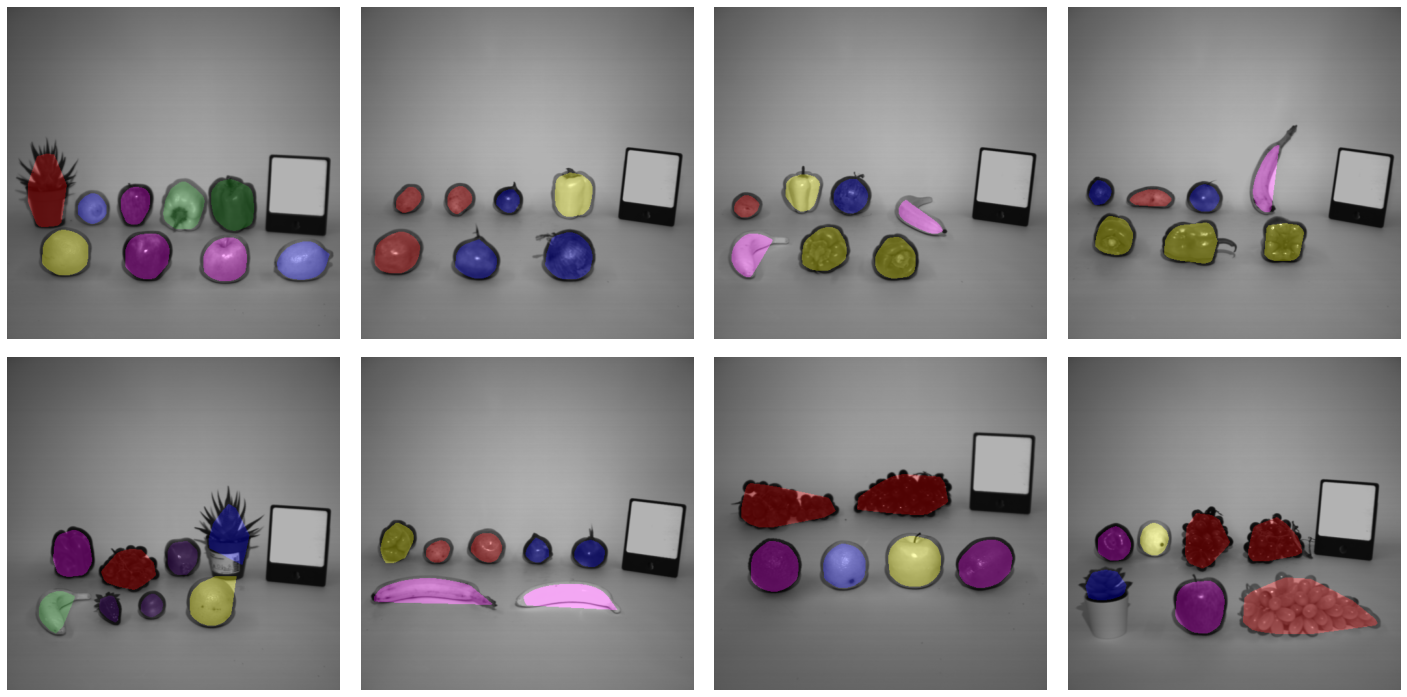

In [34]:
multicolumn = data_segmented[data_segmented.fruit.map(lambda x: '/' in x)]
fig, axes = plt.subplots(2,4,figsize=[20,10], tight_layout=True)
for ax in axes.flatten():
    sample = multicolumn.sample(1)
    fname = sample.names.values[0]
    mask = read_mask(fname)
    rgb = read_rgb_fruit(fname)
    hyspec = read_image_fruit(fname)
    fruit = FruitSegmentation(rgb, mask, hyspec)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    fruit.show_colorized(ax=ax)
fig.subplots_adjust(hspace=0.0, wspace=0.0)
# fig.savefig('figures/dataset/segmented2.pdf', transparent=True, dpi = 300)
fig.show()

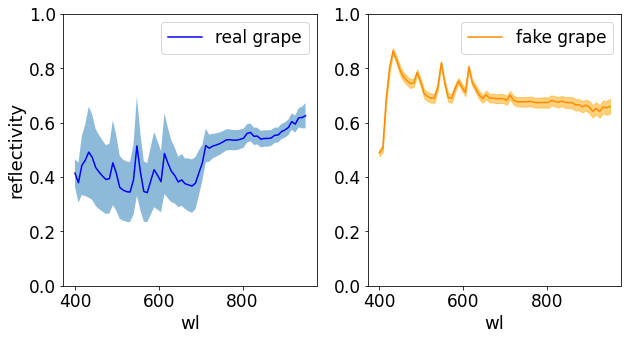

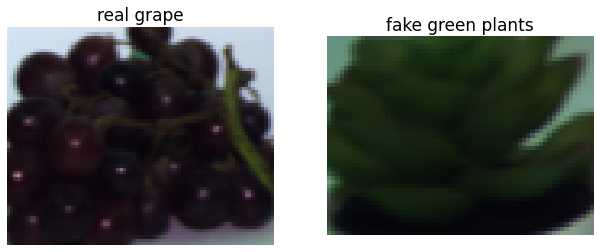

In [42]:
fruit.fit()
fruit.eval_color()
regions = [1,4]
plt.figure(figsize=[10,5])
plt.subplot(121)
mu = fruit.mu_spectral[regions[0]]
std = fruit.std_spectral[regions[0]]
#plt.plot(wl, fruit.mu_spectral[regions[0]],label='region' + str(regions[0]))
plt.fill_between(wl, mu - std/2, mu + std/2, alpha=0.5)
plt.plot(wl, mu,label='real grape',color='b')
plt.xlabel('wl')
plt.ylabel('reflectivity')
plt.legend()
plt.ylim(0,1)
plt.subplot(122)
mu = fruit.mu_spectral[regions[1]]
std = fruit.std_spectral[regions[1]]
plt.fill_between(wl, mu - std/2, mu + std/2, alpha=0.5, color='orange')
plt.plot(wl, mu,label='fake grape',color='darkorange')
plt.xlabel('wl')
plt.ylim(0,1)
plt.legend()
plt.show()
plt.figure(figsize=[10.5,5])
plt.subplot(121)
fruit.show_region(regions[0])
plt.subplot(122)
fruit.show_region(regions[1])
plt.show()

real green plants
recovered real unknown
fake green plants
recovered fake unknown


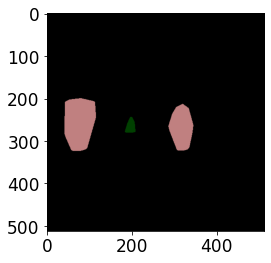

real apple
recovered real apple
fake apple
recovered fake apple


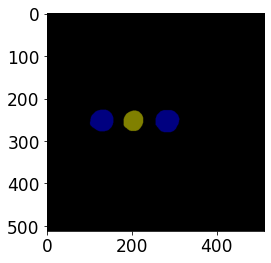

real green plants
recovered real unknown


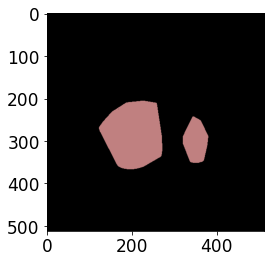

real green plants
recovered real unknown


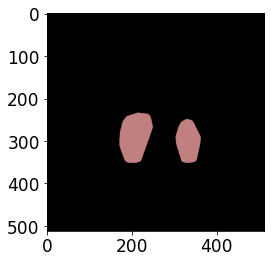

fake apple
recovered fake apple


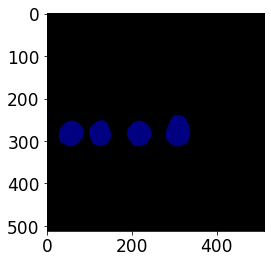

real grape
recovered real grape
fake green plants
recovered fake unknown
real lemons
recovered real lemons
fake avocado
recovered fake avocado


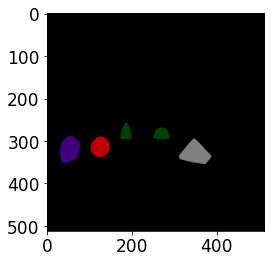

real orange
recovered real orange
fake orange
recovered fake orange


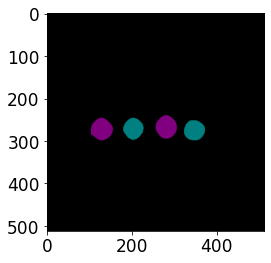

real apple
recovered real apple


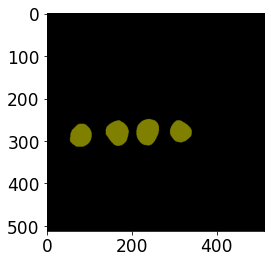

real orange
recovered real orange
fake orange
recovered fake orange


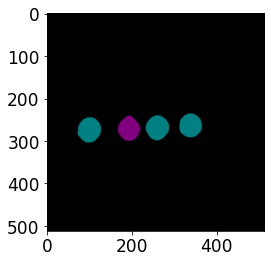

fake grape
recovered fake grape


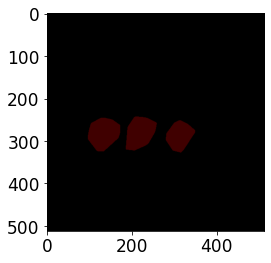

real pepper
recovered real pepper
fake pepper
recovered fake pepper


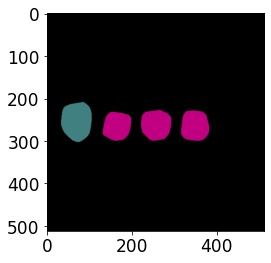

real orange
recovered real orange
fake orange
recovered fake orange


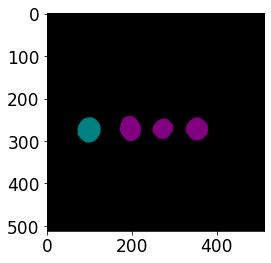

fake apple
recovered fake apple


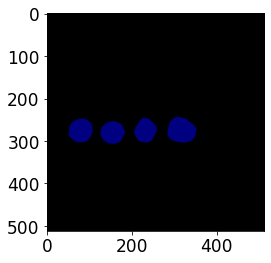

fake orange
recovered fake orange
real apple
recovered real apple
fake apple
recovered fake apple
fake unknown
recovered fake unknown


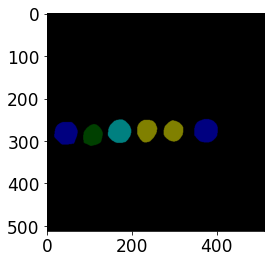

real grape
recovered real grape


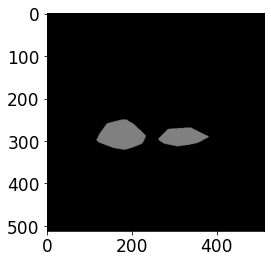

real orange
recovered real orange


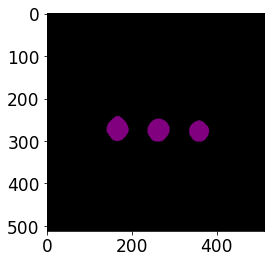

real lemons
recovered real lemons
fake lemons
recovered fake lemons


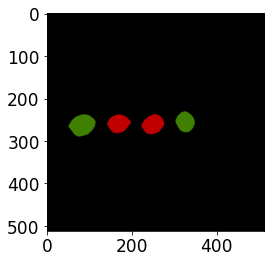

real pepper
recovered real pepper


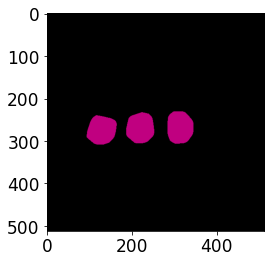

fake green plants
recovered fake unknown


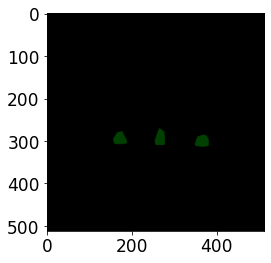

fake pepper
recovered fake pepper


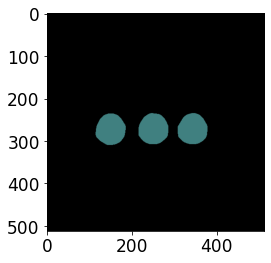

real lemons
recovered real lemons
fake lemons
recovered fake lemons


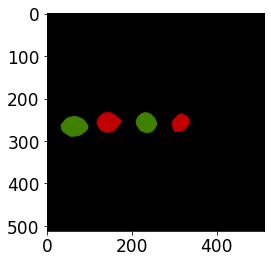

fake pepper
recovered fake pepper


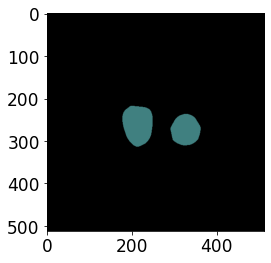

real avocado
recovered real avocado


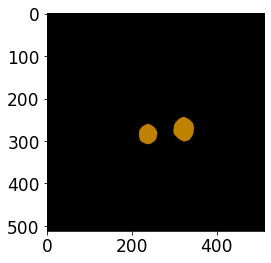

real green plants
recovered real unknown
fake green plants
recovered fake unknown


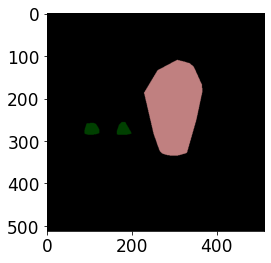

real grape
recovered real grape
fake grape
recovered fake grape
real orange
recovered real orange
real unknown
recovered real unknown


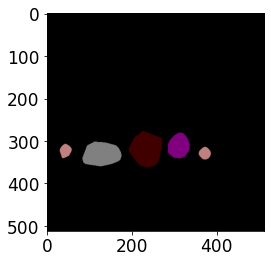

fake lemons
recovered fake lemons
real orange
recovered real orange
fake orange
recovered fake orange
real apple
recovered real apple
fake apple
recovered fake apple


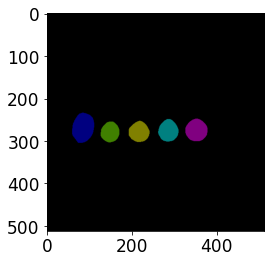

real avocado
recovered real avocado
fake avocado
recovered fake avocado


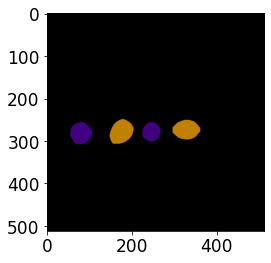

real grape
recovered real grape


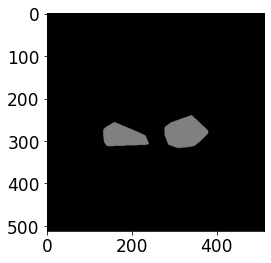

real grape
recovered real grape


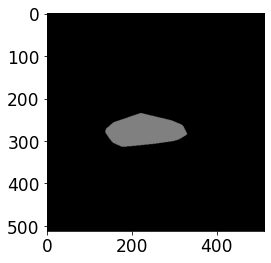

fake grape
recovered fake grape
real green plants
recovered real unknown
fake green plants
recovered fake unknown
real pepper
recovered real pepper


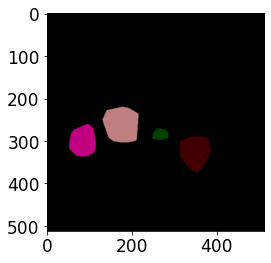

real apple
recovered real apple
fake apple
recovered fake apple


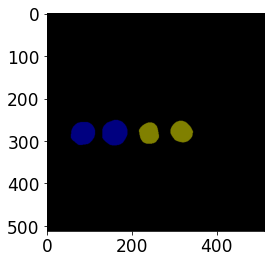

real orange
recovered real orange
real apple
recovered real apple


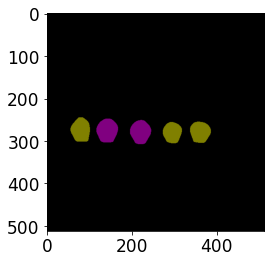

fake orange
recovered fake orange


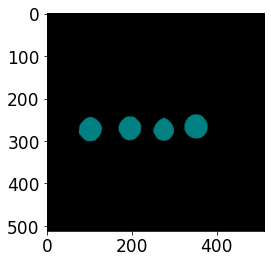

real orange
recovered real orange
fake orange
recovered fake orange
fake bananas
recovered fake unknown
real unknown
recovered real unknown
fake starfruit
recovered fake unknown


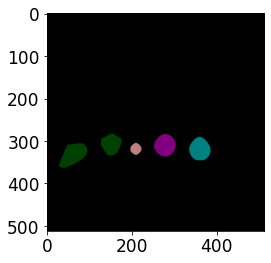

fake orange
recovered fake orange


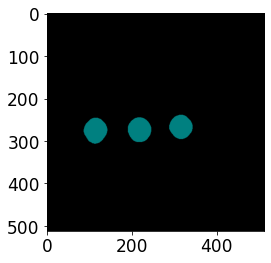

real orange
recovered real orange
fake orange
recovered fake orange


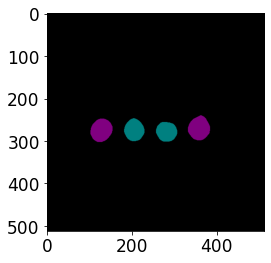

real lemons
recovered real lemons
fake lemons
recovered fake lemons


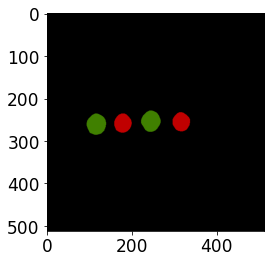

fake avocado
recovered fake avocado


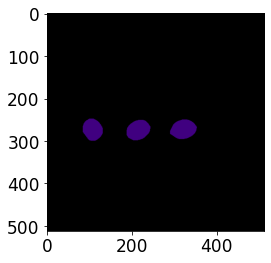

real lemons
recovered real lemons
fake lemons
recovered fake lemons
real orange
recovered real orange
fake orange
recovered fake orange


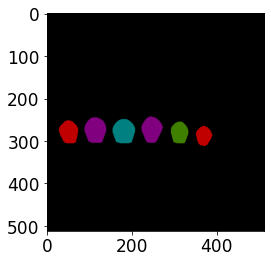

real avocado
recovered real avocado


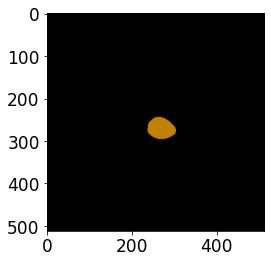

fake avocado
recovered fake avocado


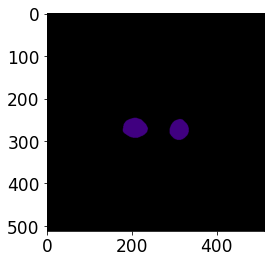

real grape
recovered real grape
fake grape
recovered fake grape
real lemons
recovered real lemons
fake lemons
recovered fake lemons
fake orange
recovered fake orange
real apple
recovered real apple


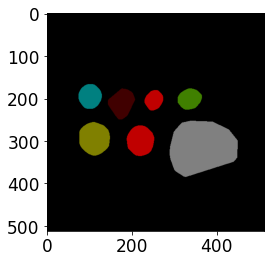

real lemons
recovered real lemons
fake orange
recovered fake orange
fake avocado
recovered fake avocado


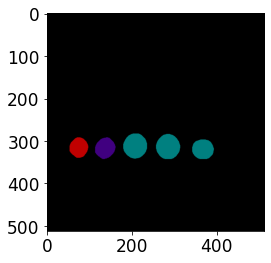

real green plants
recovered real unknown
fake green plants
recovered fake unknown


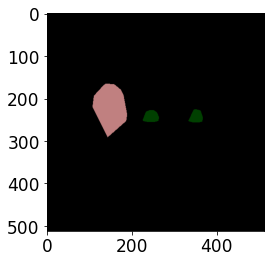

real green plants
recovered real unknown
fake lemons
recovered fake lemons
real apple
recovered real apple
fake bananas
recovered fake unknown


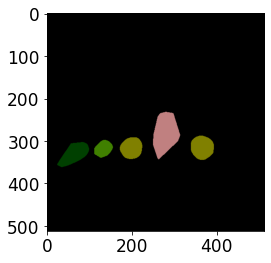

real avocado
recovered real avocado


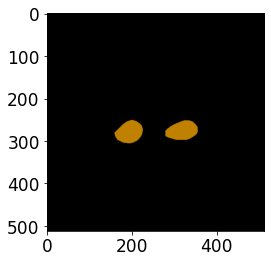

real grape
recovered real grape
fake grape
recovered fake grape


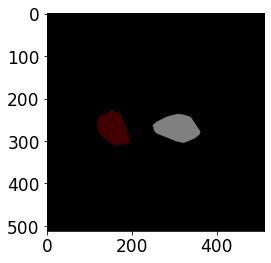

real apple
recovered real apple


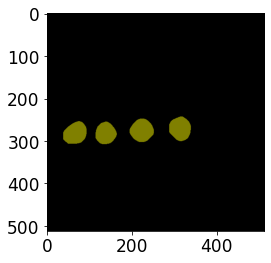

real avocado
recovered real avocado
fake avocado
recovered fake avocado


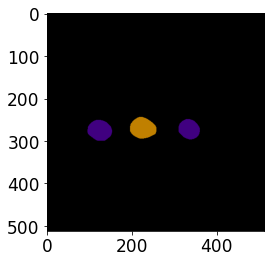

real lemons
recovered real lemons
fake lemons
recovered fake lemons


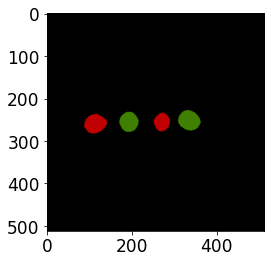

fake apple
recovered fake apple


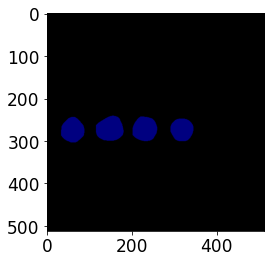

fake orange
recovered fake orange


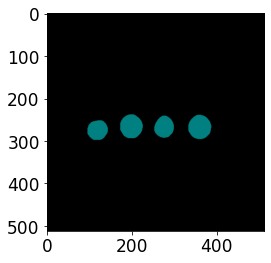

real lemons
recovered real lemons
fake orange
recovered fake orange
real apple
recovered real apple
fake apple
recovered fake apple
real avocado
recovered real avocado


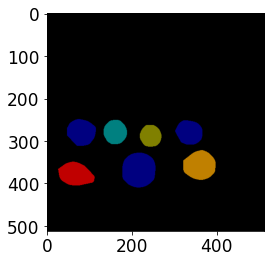

real green plants
recovered real unknown


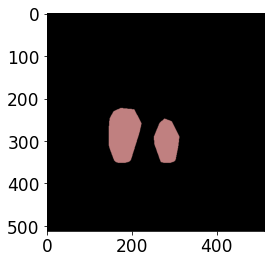

real grape
recovered real grape
fake grape
recovered fake grape


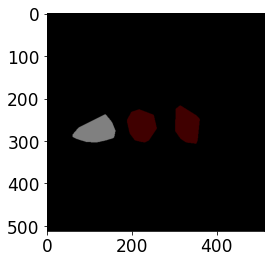

fake avocado
recovered fake avocado


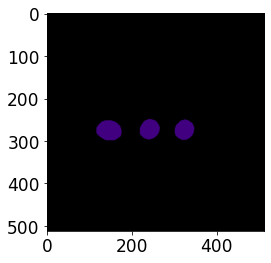

fake orange
recovered fake orange
fake apple
recovered fake apple
fake unknown
recovered fake unknown


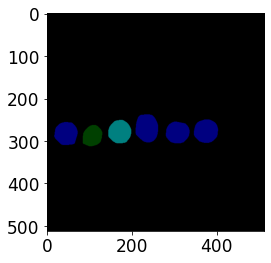

fake green plants
recovered fake unknown


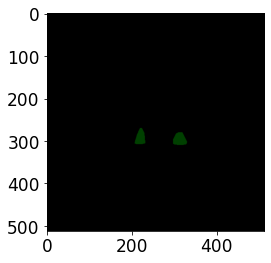

fake avocado
recovered fake avocado


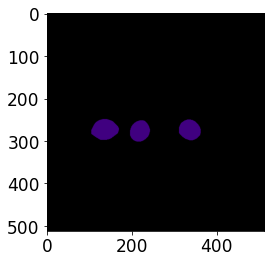

fake orange
recovered fake orange


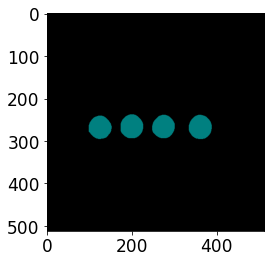

real apple
recovered real apple


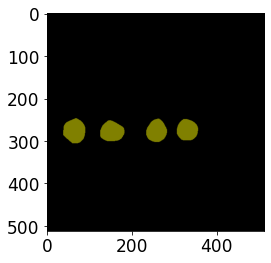

real pepper
recovered real pepper


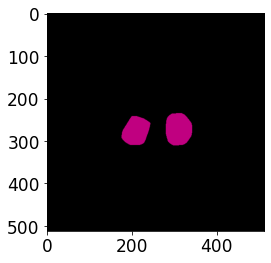

real grape
recovered real grape
fake grape
recovered fake grape
real apple
recovered real apple
fake bananas
recovered fake unknown


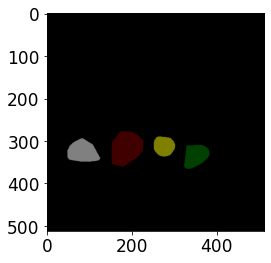

real grape
recovered real grape
fake green plants
recovered fake unknown
real lemons
recovered real lemons
fake lemons
recovered fake lemons
fake apple
recovered fake apple
fake unknown
recovered fake unknown
fake starfruit
recovered fake unknown


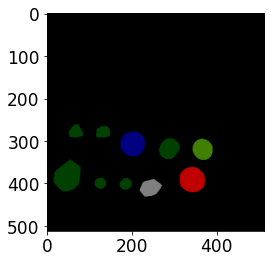

fake grape
recovered fake grape
fake lemons
recovered fake lemons
real orange
recovered real orange
real apple
recovered real apple
fake apple
recovered fake apple
real pepper
recovered real pepper


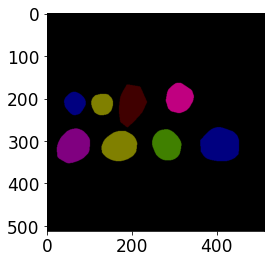

real green plants
recovered real unknown
fake green plants
recovered fake unknown


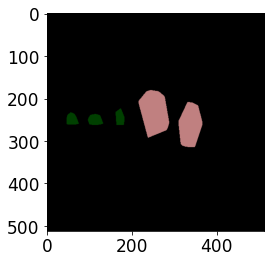

real avocado
recovered real avocado


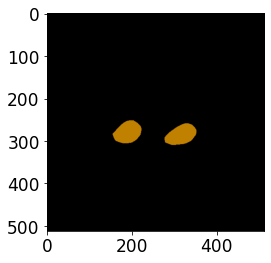

real grape
recovered real grape


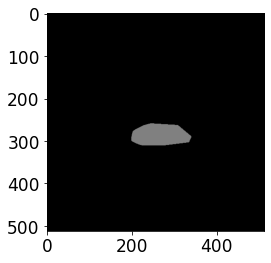

real apple
recovered real apple


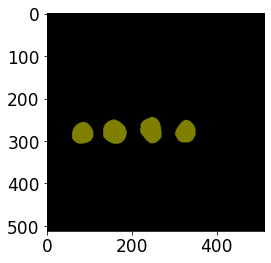

real grape
recovered real grape
fake grape
recovered fake grape


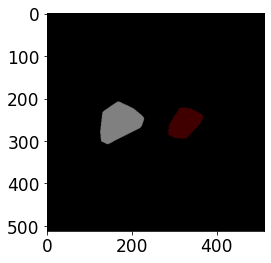

real apple
recovered real apple
fake apple
recovered fake apple
real pepper
recovered real pepper
fake avocado
recovered fake avocado


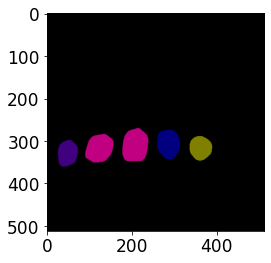

real green plants
recovered real unknown
real lemons
recovered real lemons
fake apple
recovered fake apple
real pepper
recovered real pepper
fake bananas
recovered fake unknown


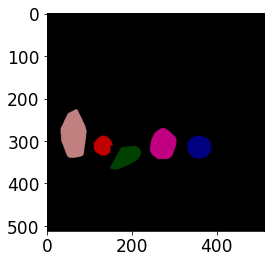

real pepper
recovered real pepper
fake pepper
recovered fake pepper


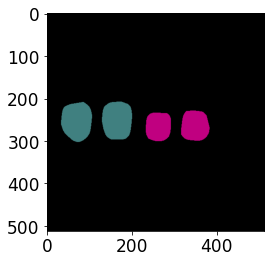

fake grape
recovered fake grape
real lemons
recovered real lemons
fake lemons
recovered fake lemons
real orange
recovered real orange
real apple
recovered real apple
fake apple
recovered fake apple
real pepper
recovered real pepper


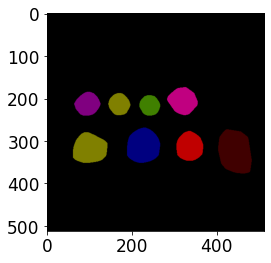

real green plants
recovered real unknown
real pepper
recovered real pepper
real avocado
recovered real avocado


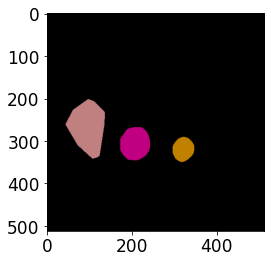

fake grape
recovered fake grape


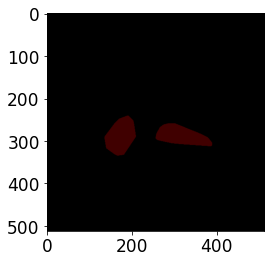

fake grape
recovered fake grape


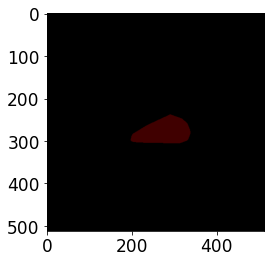

fake apple
recovered fake apple


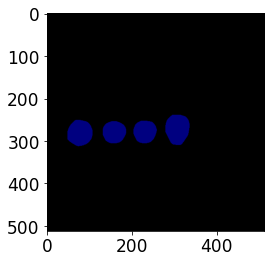

real apple
recovered real apple


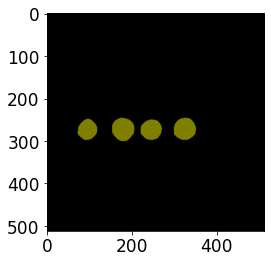

real apple
recovered real apple
fake apple
recovered fake apple


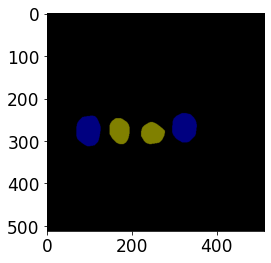

fake avocado
recovered fake avocado


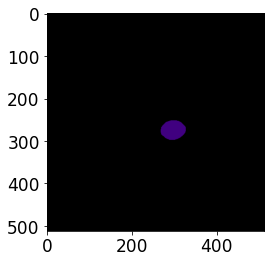

real grape
recovered real grape


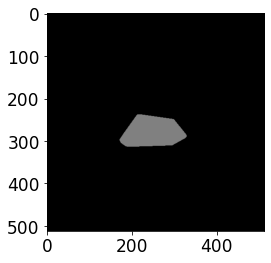

fake pepper
recovered fake pepper


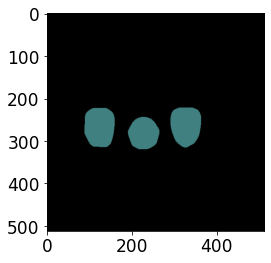

real green plants
recovered real unknown


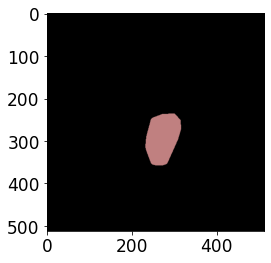

real lemons
recovered real lemons
fake lemons
recovered fake lemons
real apple
recovered real apple
fake pepper
recovered fake pepper
fake unknown
recovered fake unknown
fake avocado
recovered fake avocado


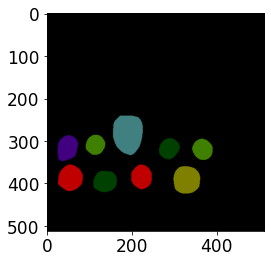

real avocado
recovered real avocado
fake avocado
recovered fake avocado


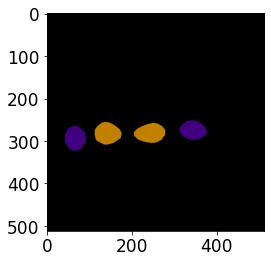

real grape
recovered real grape
real green plants
recovered real unknown
fake green plants
recovered fake unknown
fake unknown
recovered fake unknown


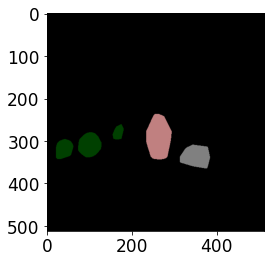

real grape
recovered real grape
fake grape
recovered fake grape
real lemons
recovered real lemons
fake lemons
recovered fake lemons
real apple
recovered real apple
real pepper
recovered real pepper


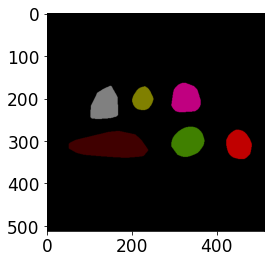

real lemons
recovered real lemons
fake lemons
recovered fake lemons


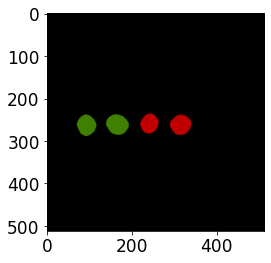

real lemons
recovered real lemons
real apple
recovered real apple
real unknown
recovered real unknown
fake avocado
recovered fake avocado


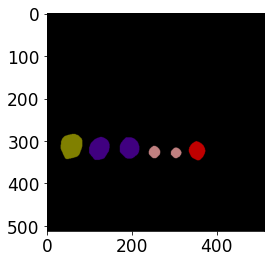

real orange
recovered real orange
fake orange
recovered fake orange


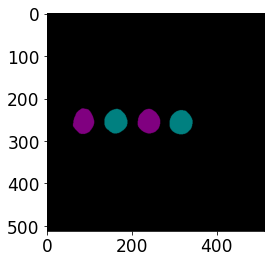

fake grape
recovered fake grape
real lemons
recovered real lemons
real orange
recovered real orange
fake orange
recovered fake orange
fake apple
recovered fake apple
real pepper
recovered real pepper


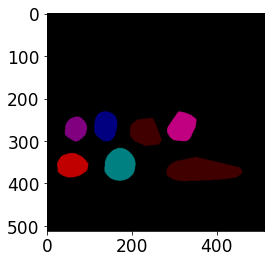

real green plants
recovered real unknown
real lemons
recovered real lemons
real orange
recovered real orange
real apple
recovered real apple
real pepper
recovered real pepper


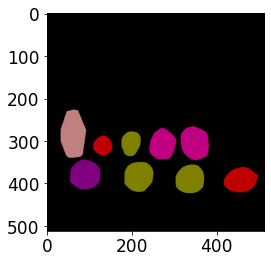

real grape
recovered real grape
fake grape
recovered fake grape
real lemons
recovered real lemons
fake apple
recovered fake apple
real avocado
recovered real avocado
fake avocado
recovered fake avocado


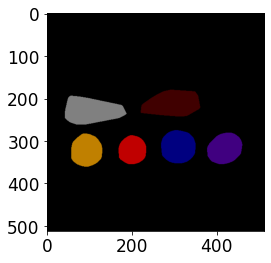

fake apple
recovered fake apple


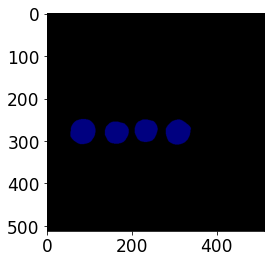

real pepper
recovered real pepper
fake pepper
recovered fake pepper


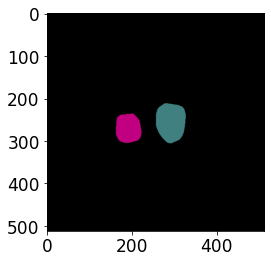

real pepper
recovered real pepper


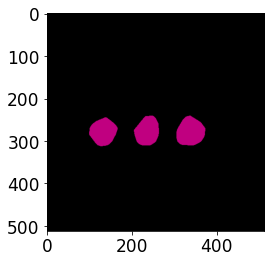

real green plants
recovered real unknown
fake green plants
recovered fake unknown


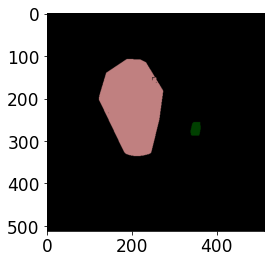

real green plants
recovered real unknown


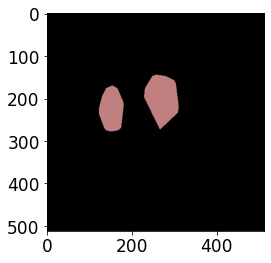

real apple
recovered real apple
fake apple
recovered fake apple


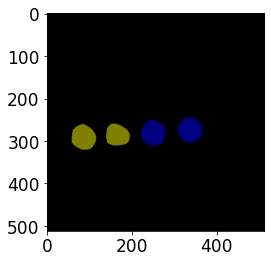

fake pepper
recovered fake pepper


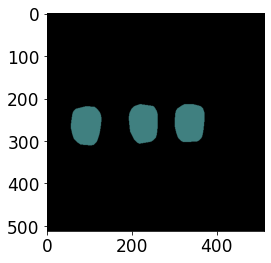

real pepper
recovered real pepper
fake pepper
recovered fake pepper


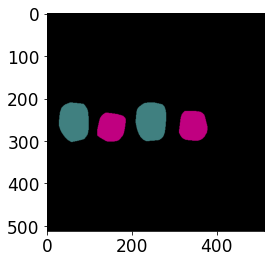

fake grape
recovered fake grape
fake lemons
recovered fake lemons
fake orange
recovered fake orange
real apple
recovered real apple
real pepper
recovered real pepper


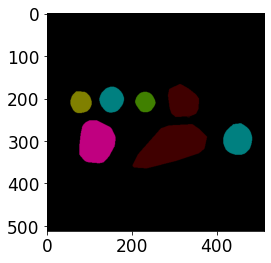

real lemons
recovered real lemons
fake lemons
recovered fake lemons


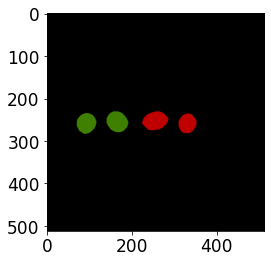

fake grape
recovered fake grape


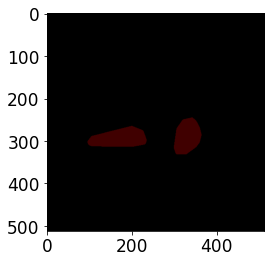

real apple
recovered real apple


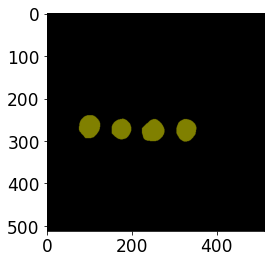

real avocado
recovered real avocado


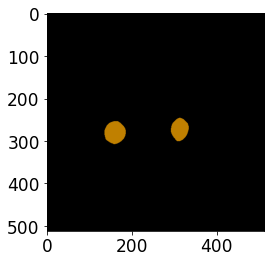

real pepper
recovered real pepper


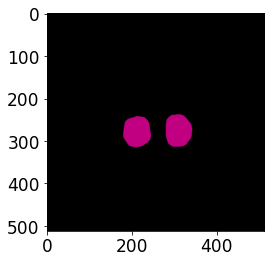

real avocado
recovered real avocado
fake avocado
recovered fake avocado


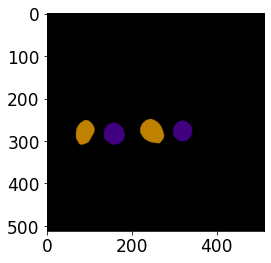

fake grape
recovered fake grape
real apple
recovered real apple
real pepper
recovered real pepper
fake unknown
recovered fake unknown


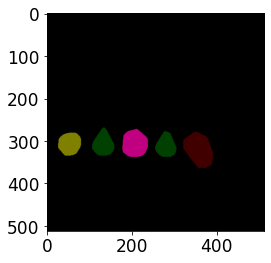

fake apple
recovered fake apple


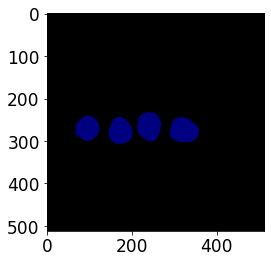

real grape
recovered real grape
real green plants
recovered real unknown
real orange
recovered real orange
real pepper
recovered real pepper
fake bananas
recovered fake unknown
real unknown
recovered real unknown
fake unknown
recovered fake unknown


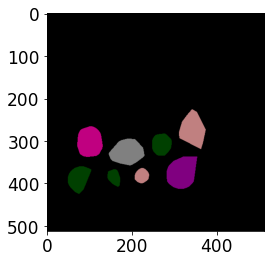

fake grape
recovered fake grape
fake green plants
recovered fake unknown
real pepper
recovered real pepper
fake unknown
recovered fake unknown


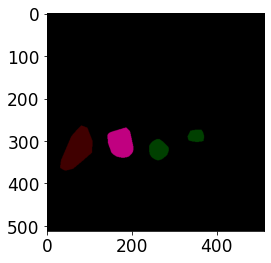

fake orange
recovered fake orange


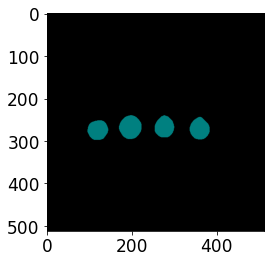

real green plants
recovered real unknown


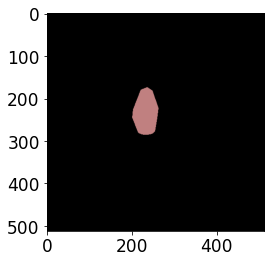

fake orange
recovered fake orange
fake bananas
recovered fake unknown
real avocado
recovered real avocado
fake starfruit
recovered fake unknown


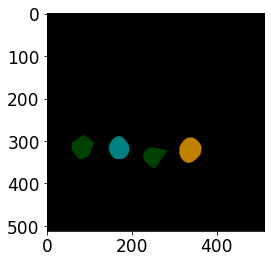

real grape
recovered real grape
fake grape
recovered fake grape


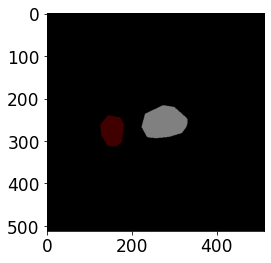

real pepper
recovered real pepper


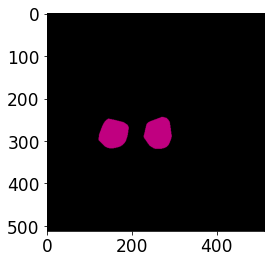

fake grape
recovered fake grape
real orange
recovered real orange
real apple
recovered real apple
fake apple
recovered fake apple
real unknown
recovered real unknown


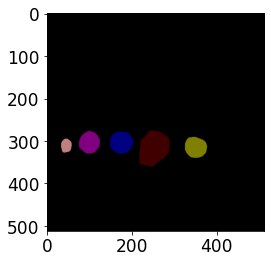

real apple
recovered real apple


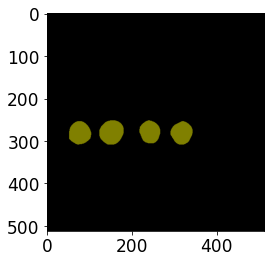

real apple
recovered real apple
fake apple
recovered fake apple


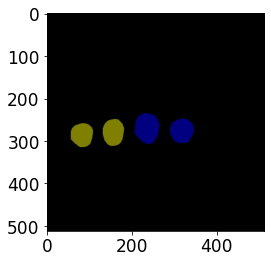

real apple
recovered real apple
fake apple
recovered fake apple


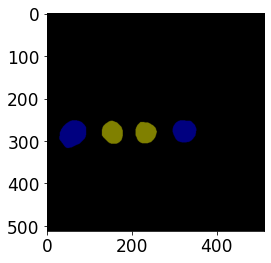

real lemons
recovered real lemons
fake lemons
recovered fake lemons


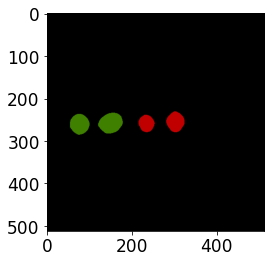

real green plants
recovered real unknown
fake green plants
recovered fake unknown
real lemons
recovered real lemons
fake apple
recovered fake apple
fake unknown
recovered fake unknown


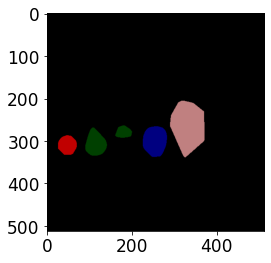

fake grape
recovered fake grape
fake apple
recovered fake apple
real pepper
recovered real pepper
fake unknown
recovered fake unknown


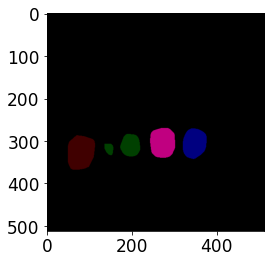

real grape
recovered real grape
fake grape
recovered fake grape


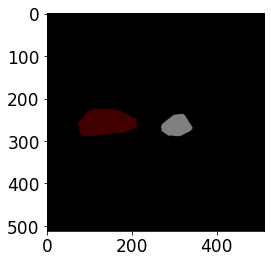

real apple
recovered real apple


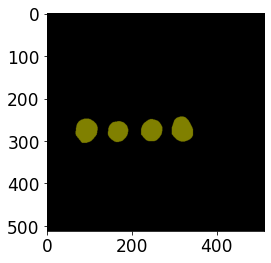

fake grape
recovered fake grape
real green plants
recovered real unknown
fake apple
recovered fake apple
fake bananas
recovered fake unknown
fake unknown
recovered fake unknown


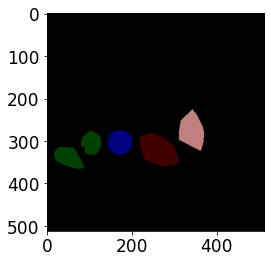

real grape
recovered real grape
fake green plants
recovered fake unknown
real avocado
recovered real avocado
fake starfruit
recovered fake unknown


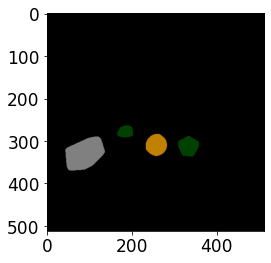

real grape
recovered real grape
real orange
recovered real orange
real apple
recovered real apple
real pepper
recovered real pepper
fake bananas
recovered fake unknown


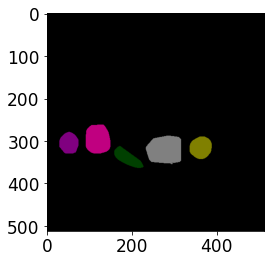

real grape
recovered real grape
real green plants
recovered real unknown
fake green plants
recovered fake unknown


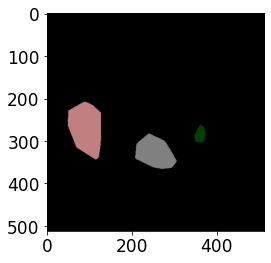

real orange
recovered real orange


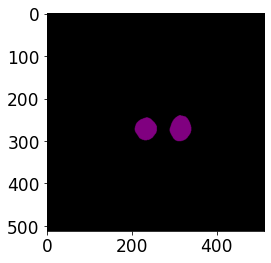

real grape
recovered real grape


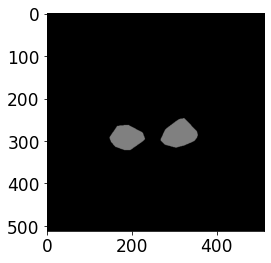

fake green plants
recovered fake unknown
real lemons
recovered real lemons
fake lemons
recovered fake lemons
fake pepper
recovered fake pepper
real unknown
recovered real unknown


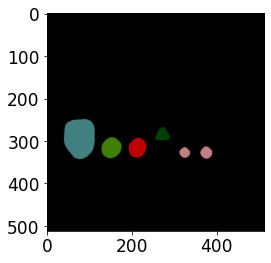

real pepper
recovered real pepper
fake pepper
recovered fake pepper


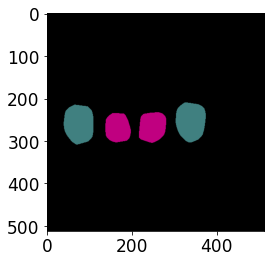

real lemons
recovered real lemons
fake lemons
recovered fake lemons


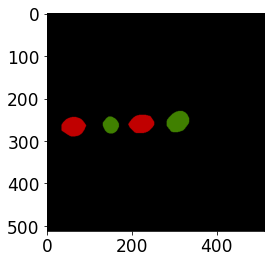

real apple
recovered real apple


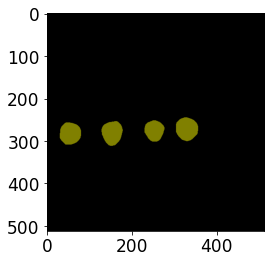

real grape
recovered real grape
real lemons
recovered real lemons
fake lemons
recovered fake lemons
real orange
recovered real orange
fake orange
recovered fake orange
fake apple
recovered fake apple


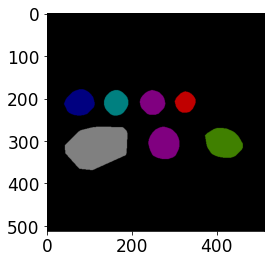

fake grape
recovered fake grape
real lemons
recovered real lemons
real orange
recovered real orange
fake orange
recovered fake orange
real apple
recovered real apple
fake apple
recovered fake apple


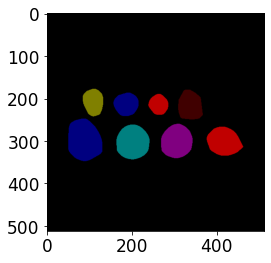

real green plants
recovered real unknown
fake green plants
recovered fake unknown


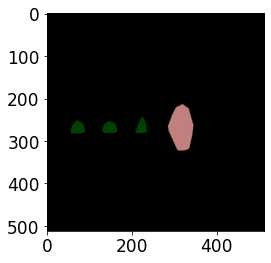

fake apple
recovered fake apple
real pepper
recovered real pepper
fake pepper
recovered fake pepper
fake bananas
recovered fake unknown
real unknown
recovered real unknown
fake unknown
recovered fake unknown
fake avocado
recovered fake avocado


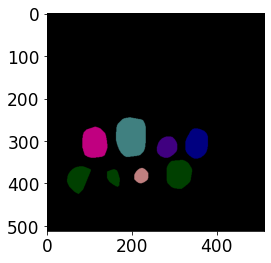

fake apple
recovered fake apple


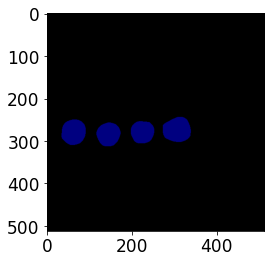

real grape
recovered real grape
fake grape
recovered fake grape
real lemons
recovered real lemons
fake lemons
recovered fake lemons
real orange
recovered real orange
fake orange
recovered fake orange


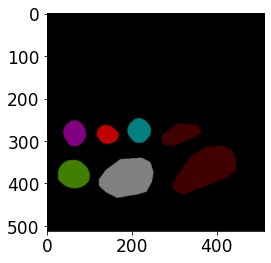

real avocado
recovered real avocado
fake avocado
recovered fake avocado


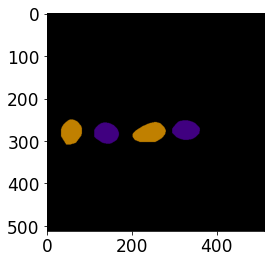

fake grape
recovered fake grape


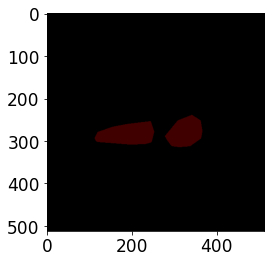

fake grape
recovered fake grape


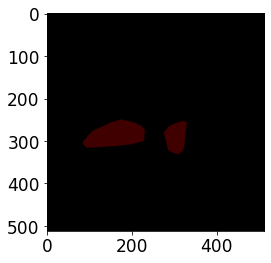

fake grape
recovered fake grape


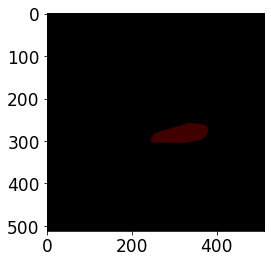

real apple
recovered real apple
fake apple
recovered fake apple


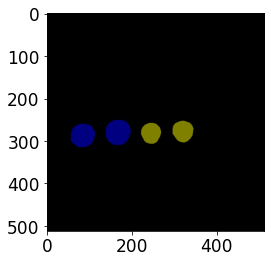

real apple
recovered real apple


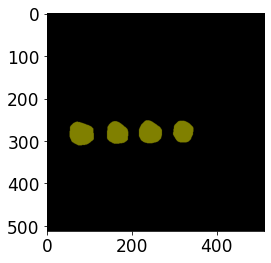

real grape
recovered real grape
fake grape
recovered fake grape


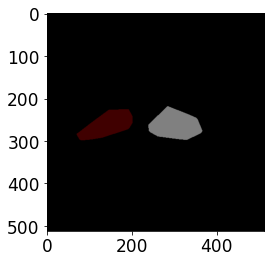

real grape
recovered real grape
fake green plants
recovered fake unknown
real lemons
recovered real lemons
real pepper
recovered real pepper


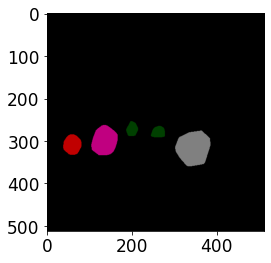

real orange
recovered real orange


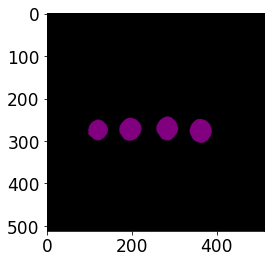

real green plants
recovered real unknown
fake green plants
recovered fake unknown


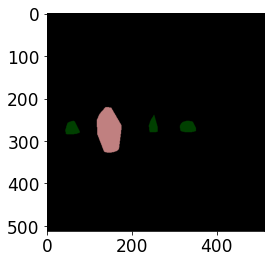

fake grape
recovered fake grape
real lemons
recovered real lemons
fake orange
recovered fake orange
fake apple
recovered fake apple
real avocado
recovered real avocado


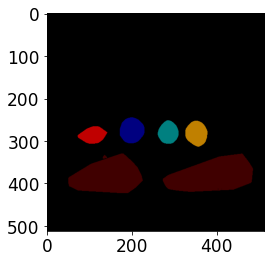

fake grape
recovered fake grape
real green plants
recovered real unknown
fake green plants
recovered fake unknown
fake lemons
recovered fake lemons
real apple
recovered real apple
fake apple
recovered fake apple


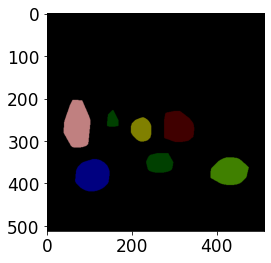

real orange
recovered real orange


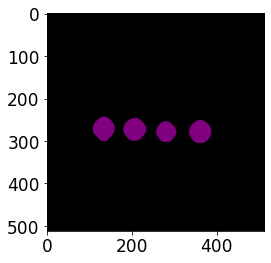

real green plants
recovered real unknown
fake green plants
recovered fake unknown


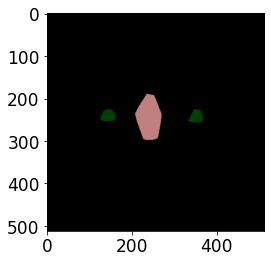

fake grape
recovered fake grape


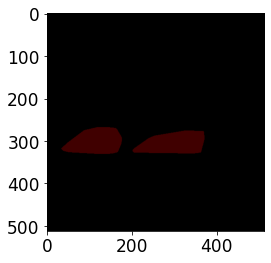

fake grape
recovered fake grape


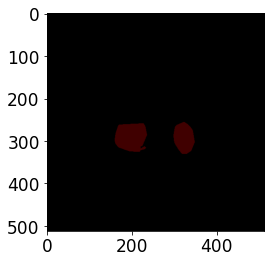

fake green plants
recovered fake unknown
real orange
recovered real orange
fake apple
recovered fake apple
fake unknown
recovered fake unknown


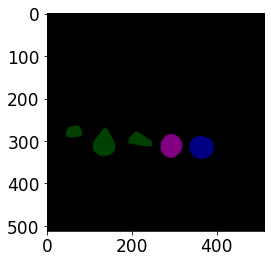

real grape
recovered real grape
real lemons
recovered real lemons
fake lemons
recovered fake lemons
real orange
recovered real orange
fake apple
recovered fake apple
real pepper
recovered real pepper


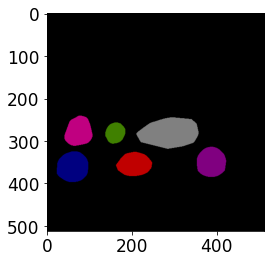

real grape
recovered real grape
fake grape
recovered fake grape


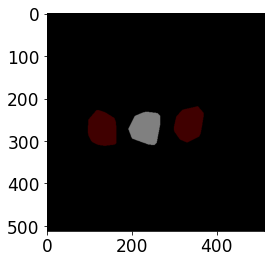

real apple
recovered real apple


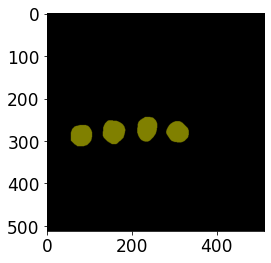

real apple
recovered real apple


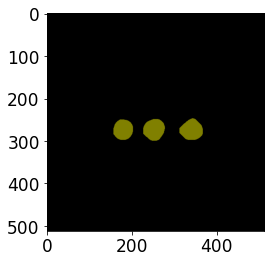

real apple
recovered real apple
fake apple
recovered fake apple


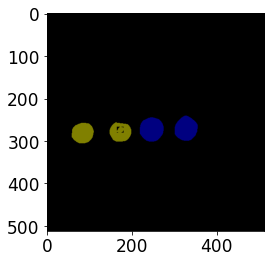

fake apple
recovered fake apple


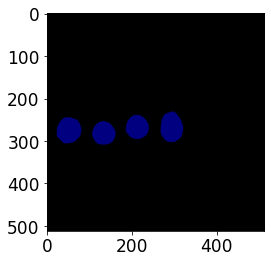

real apple
recovered real apple


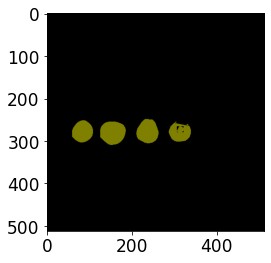

real lemons
recovered real lemons
fake lemons
recovered fake lemons


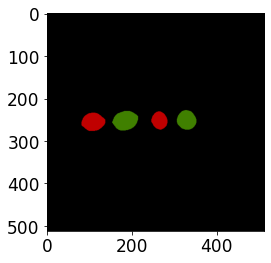

real grape
recovered real grape
fake lemons
recovered fake lemons
real orange
recovered real orange
real apple
recovered real apple
fake apple
recovered fake apple
real pepper
recovered real pepper


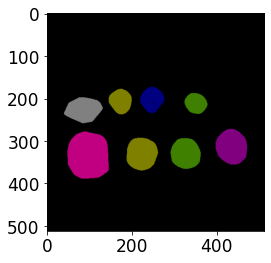

real grape
recovered real grape
fake grape
recovered fake grape


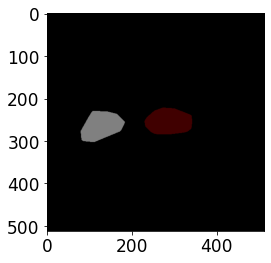

fake apple
recovered fake apple


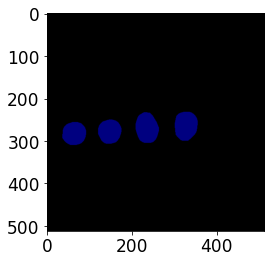

real green plants
recovered real unknown
real pepper
recovered real pepper
fake starfruit
recovered fake unknown


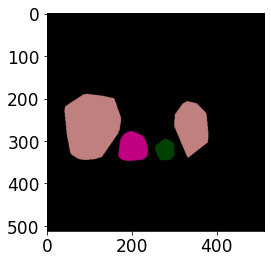

fake orange
recovered fake orange


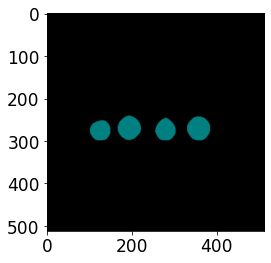

fake apple
recovered fake apple


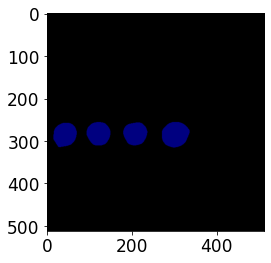

real apple
recovered real apple
fake apple
recovered fake apple


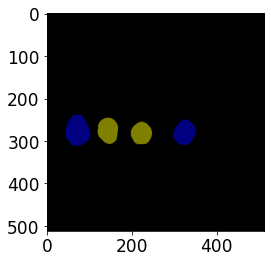

real pepper
recovered real pepper
fake pepper
recovered fake pepper


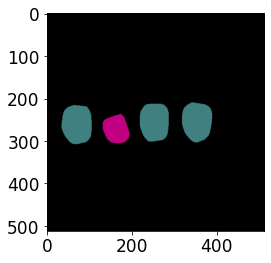

real green plants
recovered real unknown
real lemons
recovered real lemons
real orange
recovered real orange
real apple
recovered real apple


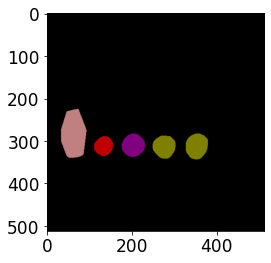

real apple
recovered real apple
fake apple
recovered fake apple


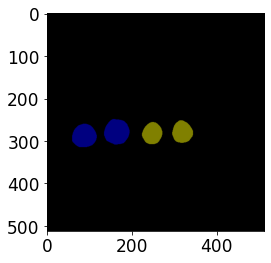

real grape
recovered real grape
fake grape
recovered fake grape
fake green plants
recovered fake unknown
fake lemons
recovered fake lemons
real apple
recovered real apple


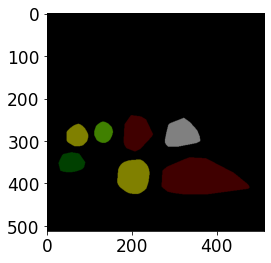

fake green plants
recovered fake unknown
real pepper
recovered real pepper
real avocado
recovered real avocado
fake starfruit
recovered fake unknown


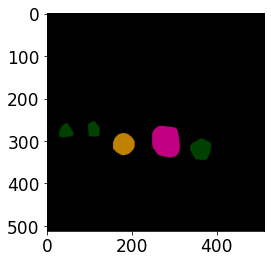

real apple
recovered real apple
fake apple
recovered fake apple


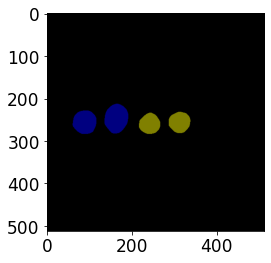

real apple
recovered real apple


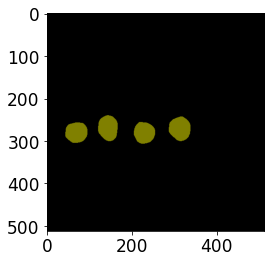

real orange
recovered real orange
fake orange
recovered fake orange


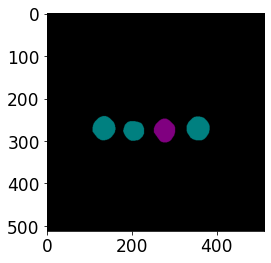

real grape
recovered real grape


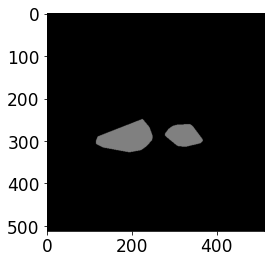

fake grape
recovered fake grape
fake green plants
recovered fake unknown
fake lemons
recovered fake lemons
fake orange
recovered fake orange
real apple
recovered real apple
real unknown
recovered real unknown
fake unknown
recovered fake unknown


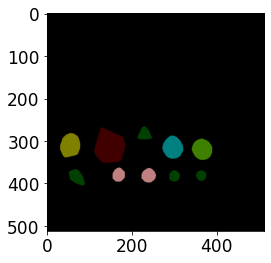

real lemons
recovered real lemons
fake lemons
recovered fake lemons


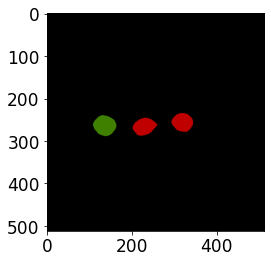

real apple
recovered real apple
fake apple
recovered fake apple


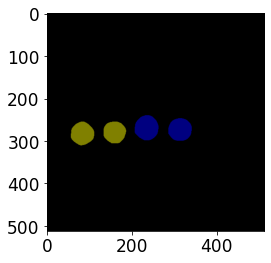

real lemons
recovered real lemons
fake lemons
recovered fake lemons


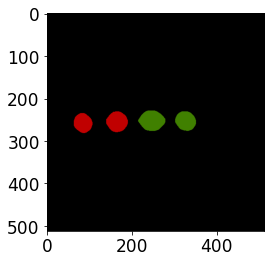

real green plants
recovered real unknown


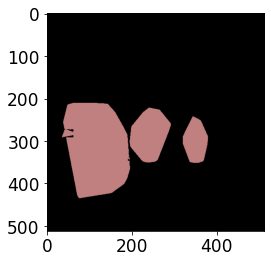

real orange
recovered real orange


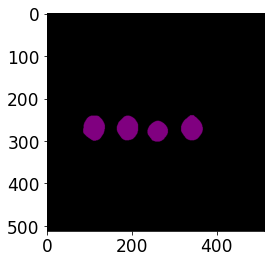

real apple
recovered real apple


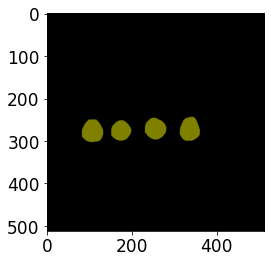

real green plants
recovered real unknown
fake green plants
recovered fake unknown


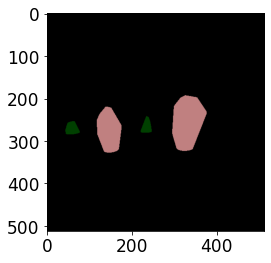

real lemons
recovered real lemons
fake lemons
recovered fake lemons


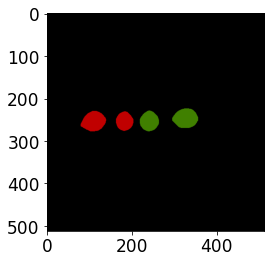

real grape
recovered real grape
fake grape
recovered fake grape


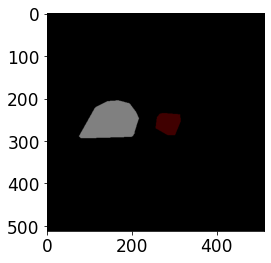

fake pepper
recovered fake pepper


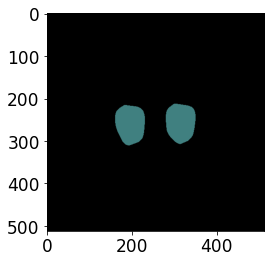

real green plants
recovered real unknown


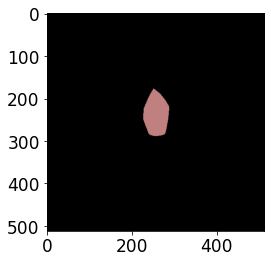

fake grape
recovered fake grape
real lemons
recovered real lemons
fake lemons
recovered fake lemons
fake orange
recovered fake orange
real apple
recovered real apple
fake apple
recovered fake apple
real pepper
recovered real pepper


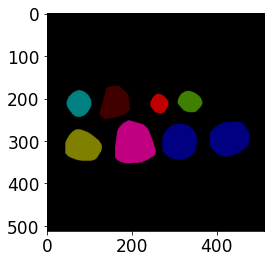

real grape
recovered real grape
fake lemons
recovered fake lemons
real apple
recovered real apple
fake apple
recovered fake apple
real pepper
recovered real pepper


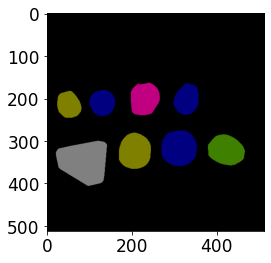

fake grape
recovered fake grape
fake apple
recovered fake apple


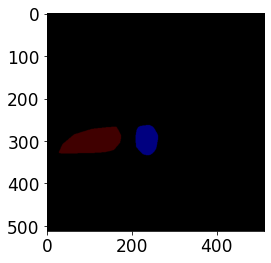

real avocado
recovered real avocado
fake avocado
recovered fake avocado


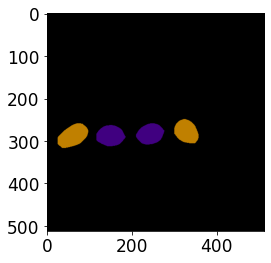

real green plants
recovered real unknown


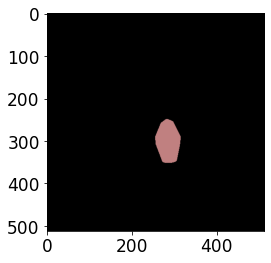

real green plants
recovered real unknown
fake green plants
recovered fake unknown


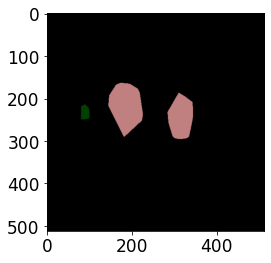

real grape
recovered real grape
fake grape
recovered fake grape
fake lemons
recovered fake lemons
real orange
recovered real orange
fake pepper
recovered fake pepper


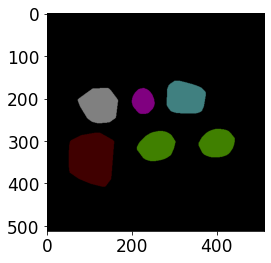

real green plants
recovered real unknown
fake green plants
recovered fake unknown


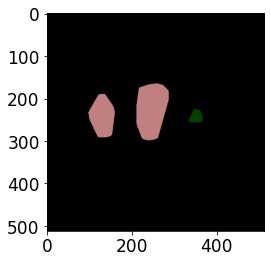

real green plants
recovered real unknown
fake green plants
recovered fake unknown
real lemons
recovered real lemons
fake orange
recovered fake orange


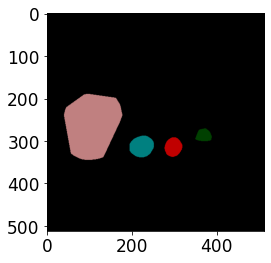

real lemons
recovered real lemons
real orange
recovered real orange
real apple
recovered real apple


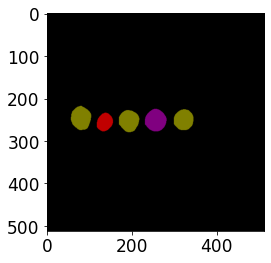

real potato
recovered real potato
fake potato
recovered fake potato
real pepper
recovered real pepper
fake bananas
recovered fake unknown


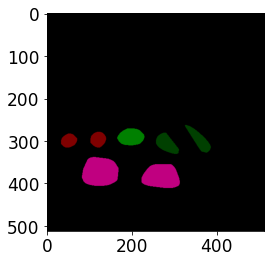

real potato
recovered real potato
fake potato
recovered fake potato
real pepper
recovered real pepper
fake pepper
recovered fake pepper
real bananas
recovered real unknown


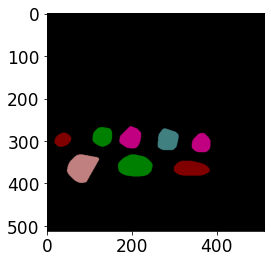

real potato
recovered real potato
real onion
recovered real unknown
real pepper
recovered real pepper
fake pepper
recovered fake pepper
fake bananas
recovered fake unknown


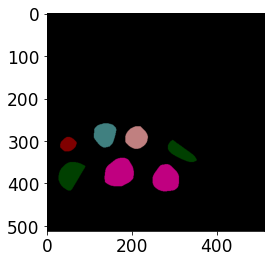

real potato
recovered real potato
real onion
recovered real unknown
fake onion
recovered fake unknown
real pepper
recovered real pepper
fake pepper
recovered fake pepper
fake bananas
recovered fake unknown


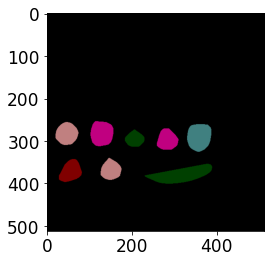

real potato
recovered real potato
fake potato
recovered fake potato
real onion
recovered real unknown
fake onion
recovered fake unknown
real pepper
recovered real pepper
fake bananas
recovered fake unknown


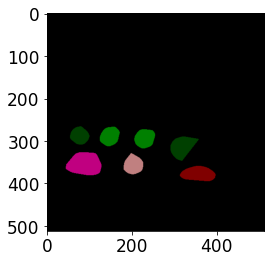

real potato
recovered real potato
fake potato
recovered fake potato
real pepper
recovered real pepper
fake pepper
recovered fake pepper
real bananas
recovered real unknown
fake bananas
recovered fake unknown


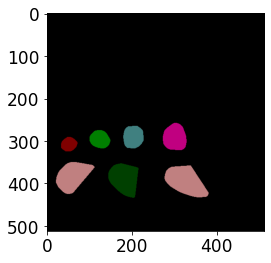

fake potato
recovered fake potato
fake onion
recovered fake unknown
real pepper
recovered real pepper
fake pepper
recovered fake pepper
real bananas
recovered real unknown


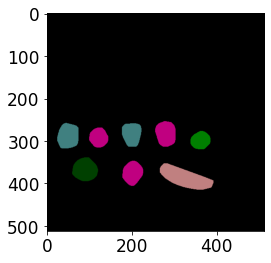

real potato
recovered real potato
fake potato
recovered fake potato
real onion
recovered real unknown
fake onion
recovered fake unknown
real pepper
recovered real pepper
real bananas
recovered real unknown


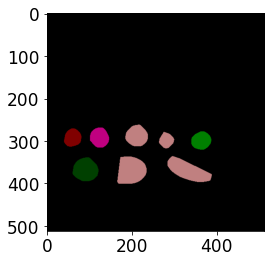

real potato
recovered real potato
fake potato
recovered fake potato
real onion
recovered real unknown
fake onion
recovered fake unknown
real pepper
recovered real pepper


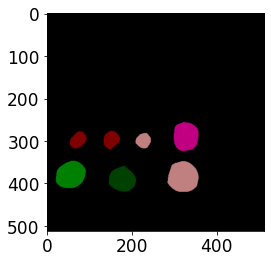

real potato
recovered real potato
fake potato
recovered fake potato
real onion
recovered real unknown
fake onion
recovered fake unknown
fake bananas
recovered fake unknown


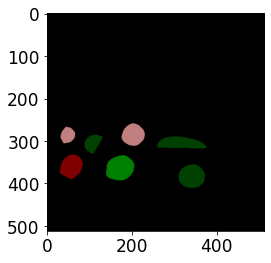

real potato
recovered real potato
fake potato
recovered fake potato
real onion
recovered real unknown
fake onion
recovered fake unknown


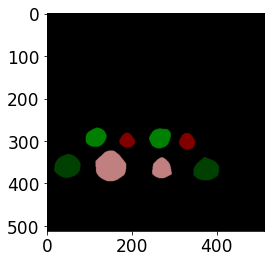

real onion
recovered real unknown
fake onion
recovered fake unknown


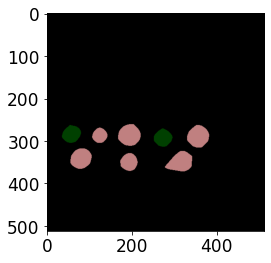

real potato
recovered real potato
fake potato
recovered fake potato
real onion
recovered real unknown


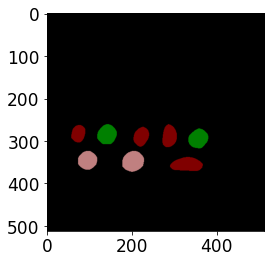

real potato
recovered real potato
fake potato
recovered fake potato
fake pepper
recovered fake pepper
real bananas
recovered real unknown


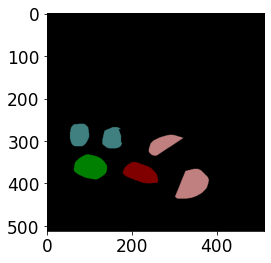

real potato
recovered real potato
real onion
recovered real unknown
fake onion
recovered fake unknown
real pepper
recovered real pepper
real bananas
recovered real unknown


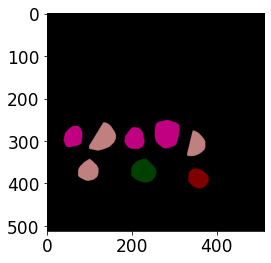

real onion
recovered real unknown
fake onion
recovered fake unknown
real pepper
recovered real pepper
real bananas
recovered real unknown
fake bananas
recovered fake unknown


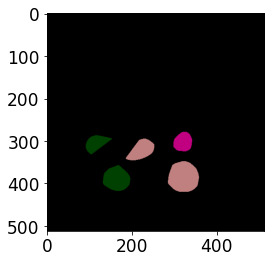

real potato
recovered real potato
fake potato
recovered fake potato
real onion
recovered real unknown
real pepper
recovered real pepper
real bananas
recovered real unknown
fake bananas
recovered fake unknown


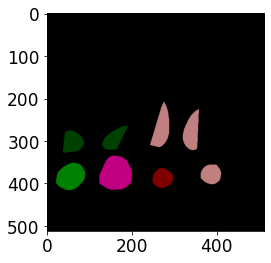

fake potato
recovered fake potato
fake onion
recovered fake unknown
fake pepper
recovered fake pepper
fake bananas
recovered fake unknown


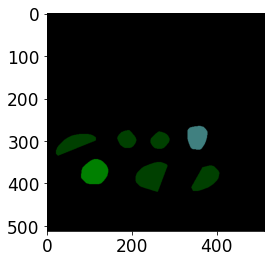

real potato
recovered real potato
fake potato
recovered fake potato
real onion
recovered real unknown
fake onion
recovered fake unknown
real pepper
recovered real pepper
real bananas
recovered real unknown


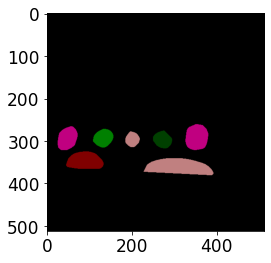

real potato
recovered real potato
fake potato
recovered fake potato
fake onion
recovered fake unknown
real pepper
recovered real pepper
fake pepper
recovered fake pepper
fake bananas
recovered fake unknown


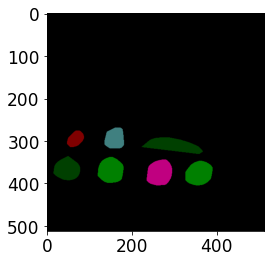

real potato
recovered real potato
fake potato
recovered fake potato
real onion
recovered real unknown
fake pepper
recovered fake pepper
real bananas
recovered real unknown


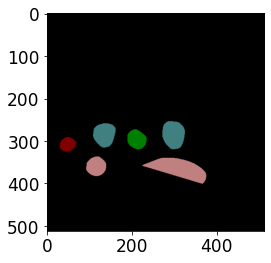

real potato
recovered real potato
fake potato
recovered fake potato
real onion
recovered real unknown
fake onion
recovered fake unknown
fake pepper
recovered fake pepper
real bananas
recovered real unknown


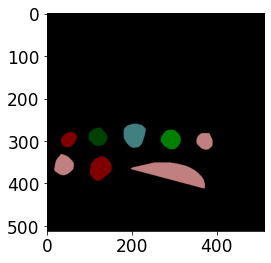

real bananas
recovered real unknown
fake bananas
recovered fake unknown


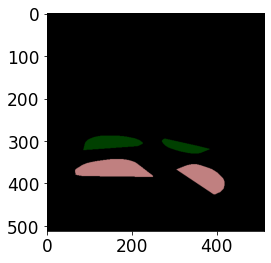

real potato
recovered real potato
real onion
recovered real unknown
fake onion
recovered fake unknown
real pepper
recovered real pepper
fake pepper
recovered fake pepper
real bananas
recovered real unknown


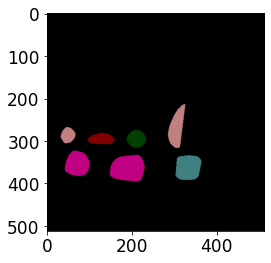

real potato
recovered real potato
fake potato
recovered fake potato
real onion
recovered real unknown
fake onion
recovered fake unknown
real pepper
recovered real pepper
fake pepper
recovered fake pepper


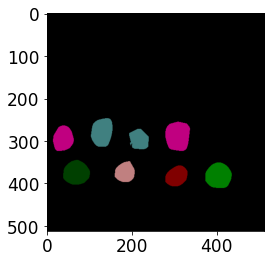

real potato
recovered real potato
real onion
recovered real unknown
fake onion
recovered fake unknown
real pepper
recovered real pepper
fake pepper
recovered fake pepper
real bananas
recovered real unknown
fake bananas
recovered fake unknown


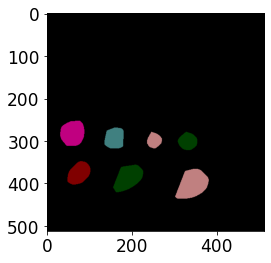

real potato
recovered real potato
real onion
recovered real unknown
fake onion
recovered fake unknown
fake pepper
recovered fake pepper
real bananas
recovered real unknown
fake bananas
recovered fake unknown


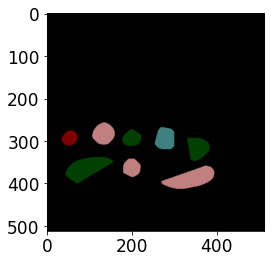

real potato
recovered real potato
fake potato
recovered fake potato
real onion
recovered real unknown
fake onion
recovered fake unknown
real pepper
recovered real pepper
fake pepper
recovered fake pepper
fake bananas
recovered fake unknown


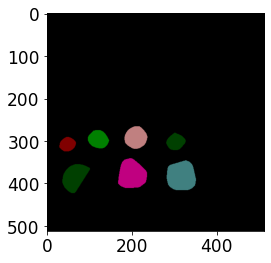

real potato
recovered real potato
fake potato
recovered fake potato
real onion
recovered real unknown
fake onion
recovered fake unknown
real pepper
recovered real pepper
fake pepper
recovered fake pepper


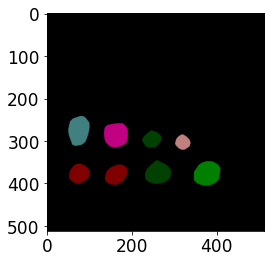

real potato
recovered real potato
fake potato
recovered fake potato
real onion
recovered real unknown
fake onion
recovered fake unknown
real pepper
recovered real pepper
real bananas
recovered real unknown
fake bananas
recovered fake unknown


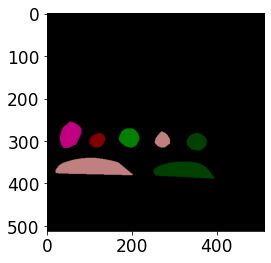

real potato
recovered real potato
real onion
recovered real unknown
real pepper
recovered real pepper
fake pepper
recovered fake pepper
real bananas
recovered real unknown
fake bananas
recovered fake unknown


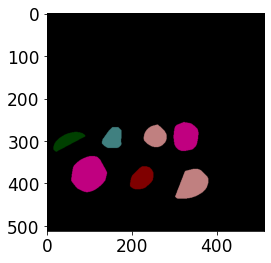

real potato
recovered real potato
fake potato
recovered fake potato
real onion
recovered real unknown
real pepper
recovered real pepper
real bananas
recovered real unknown


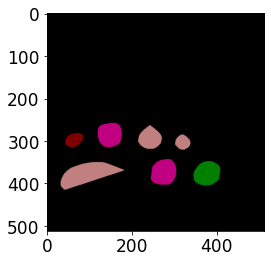

real pepper
recovered real pepper
fake pepper
recovered fake pepper
real bananas
recovered real unknown


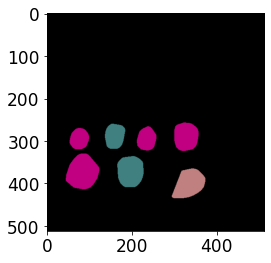

real potato
recovered real potato
real onion
recovered real unknown
real pepper
recovered real pepper
real bananas
recovered real unknown


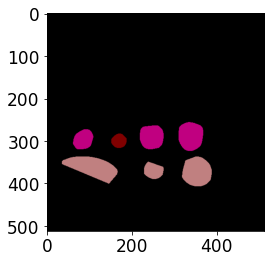

real potato
recovered real potato
real onion
recovered real unknown
fake onion
recovered fake unknown
real pepper
recovered real pepper
fake pepper
recovered fake pepper


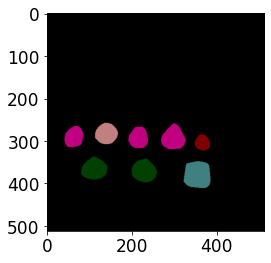

real potato
recovered real potato
fake potato
recovered fake potato
real onion
recovered real unknown
fake onion
recovered fake unknown
fake bananas
recovered fake unknown


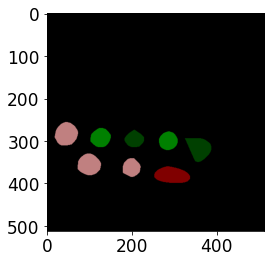

real potato
recovered real potato
fake potato
recovered fake potato
real onion
recovered real unknown
fake onion
recovered fake unknown
real pepper
recovered real pepper
fake pepper
recovered fake pepper


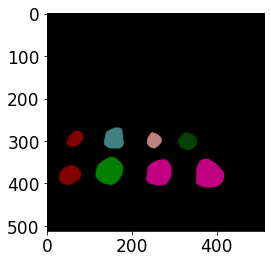

real potato
recovered real potato
real pepper
recovered real pepper
fake pepper
recovered fake pepper


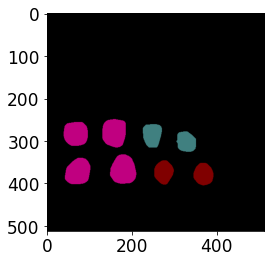

fake potato
recovered fake potato
real onion
recovered real unknown
fake onion
recovered fake unknown
real pepper
recovered real pepper
fake pepper
recovered fake pepper
fake bananas
recovered fake unknown


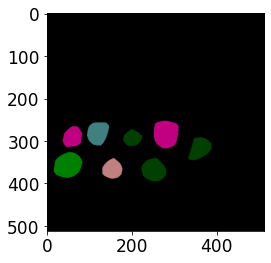

fake potato
recovered fake potato
real onion
recovered real unknown
real bananas
recovered real unknown
fake bananas
recovered fake unknown


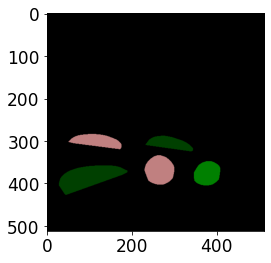

real onion
recovered real unknown
fake onion
recovered fake unknown
real bananas
recovered real unknown
fake bananas
recovered fake unknown


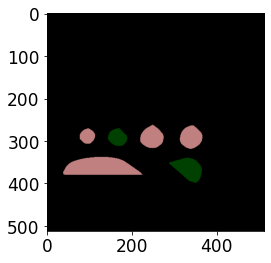

real potato
recovered real potato
fake potato
recovered fake potato
real bananas
recovered real unknown
fake bananas
recovered fake unknown


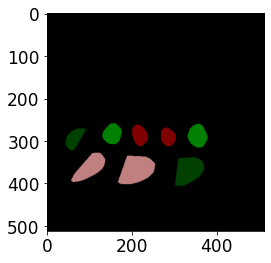

real potato
recovered real potato
fake potato
recovered fake potato
real onion
recovered real unknown
fake onion
recovered fake unknown
real pepper
recovered real pepper
fake pepper
recovered fake pepper


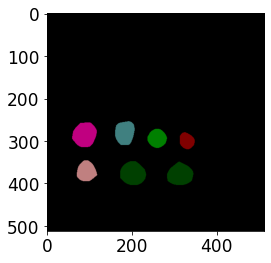

real potato
recovered real potato
fake potato
recovered fake potato
real onion
recovered real unknown
fake onion
recovered fake unknown
real pepper
recovered real pepper
fake bananas
recovered fake unknown


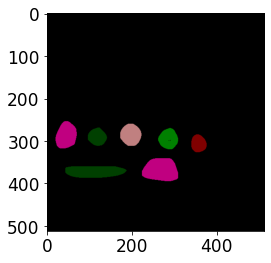

real pepper
recovered real pepper
fake pepper
recovered fake pepper


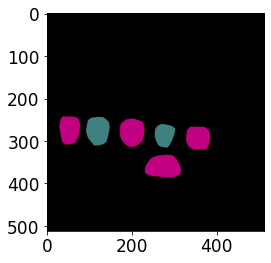

real potato
recovered real potato
fake potato
recovered fake potato
real onion
recovered real unknown
fake onion
recovered fake unknown


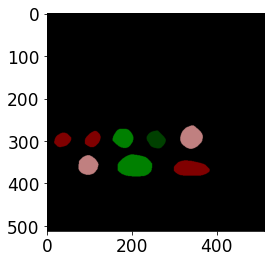

In [47]:
from segment import merge_masks, encode_dict, fruit_dict
def get_labels():
    """Load the mapping that associates pascal classes with label colors
    Returns:
        np.ndarray with dimensions (21, 3)
    """
    return np.asarray([[0, 0, 0],
                       [128, 0, 0],
                       [0, 128, 0],
                       [128, 128, 0],
                       [0, 0, 128],
                       [128, 0, 128],
                       [0, 128, 128],
                       [128, 128, 128],
                       [64, 0, 0],
                       [192, 0, 0],
                       [64, 128, 0],
                       [192, 128, 0],
                       [64, 0, 128],
                       [192, 0, 128],
                       [64, 128, 128],
                       [192, 128, 128],
                       [0, 64, 0],
                       [128, 64, 0],
                       [0, 192, 0],
                       [128, 192, 0],
                       [0, 64, 128]])

used_classes = ['bg,',
    'real potato',
    'fake potato',
    'real apple',
    'fake apple',
    'real orange',
    'fake orange',
    'real grape',
    'fake grape',
    'real lemons',
    'fake lemons',
    'real avocado',
    'fake avocado',
    'real pepper',
    'fake pepper',
    'real unknown',
    'fake unknown']

def map_labels(idx, d, l):
    label = d[idx]
    print(label)
    try:
        index = l.index(d[idx])
    except ValueError:
        rf, *_ = label.split()
        if rf == 'real':
            index = 15
        else:
            index = 16
    return index

def transform_labels(mask, d, l):
    wx, wy = mask.shape
    output = np.zeros((wx,wy,3),dtype=np.uint8)
    mask[mask == -1.0] = 0.0
    labels = sorted(np.unique(mask.flatten()))
    rgb_labels = get_labels()
    for label in labels[1:]:
        idx = map_labels(label,d,l)
        print('recovered', used_classes[idx])
        output[mask == label] = rgb_labels[idx]
    return output

encoded_dict = encode_dict(fruit_dict)
for fname in data_segmented.names.values:
    mask = read_mask(fname)
    mask = merge_masks(mask[:,:,0],mask[:,:,1])
    output = transform_labels(mask, encoded_dict, used_classes)
    plt.imshow(output)
    plt.show()